# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [64]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import os
import re
import itertools
import pandas as pd
from collections import defaultdict

In [65]:
# input file containing the surface reaction mechanism
cti_file = '../RMG-model/cantera/chem_annotated.cti'
# cti_file = 'chem_annotated.cti'
# cti_file = '../RMG-model/cantera/chem0050.cti'

In [66]:
#Default if not using SLURM array
temperature_c = 150
L_D = 0.430448223
injection_speed = 0.2

# temperature_c = 550
# L_D = 0.6111111111
# injection_speed = 0.5

In [67]:
temperature_c_options = [150, 200, 250] # ºC
# rtol_options = [1e-6, 1e-9, 1e-11]
# atol_options = [1e-15, 1e-18, 1e-21, 1e-24]
L_D_options = [0.430448223, 0.870942813, 1.300618238, 1.728748068]
injection_speed_options = [0.2, 0.3, 0.4]


settings  = list(itertools.product(temperature_c_options,
                                   L_D_options,
                                   injection_speed_options
                                  ))
print(f"Settings array is from 0 to {len(settings)-1} ")

Settings array is from 0 to 35 


In [68]:
with open('rocketman-graph_array.sh') as f:
    for l in f:
        m = re.match('#SBATCH --array=(\d+)-(\d+)', l)
        if m:
            print(l)
            start = int(m.group(1))
            end = int(m.group(2))
assert (start, end) == (0, len(settings)-1 ), "SLURM array doesn't match settings array"

#SBATCH --array=0-35%36



In [69]:
task_number = int(os.getenv('SLURM_ARRAY_TASK_ID', default='0'))
task_min = int(os.getenv('SLURM_ARRAY_TASK_MIN', default='0'))
task_max = int(os.getenv('SLURM_ARRAY_TASK_MAX', default='0'))

if task_max > 0:
    print("Using SLURM array job.")
    
    cti_file = 'chem_annotated.cti'
    print(f"Using cantera input file {os.path.abspath(cti_file)}")

    print(f"Task ID {task_number} in array from {task_min} to {task_max}")

    temperature_c, L_D, injection_speed = settings[task_number]

In [70]:
if task_number == 0:
    import json
    setting_file_directory = '..' if task_max else 'rocketman'
    with open(os.path.join(setting_file_directory,'settings.json'),'w') as fp:
        json.dump(settings, fp)

In [71]:
print(f"Initial temperature      {temperature_c :.1f} ºC")
print(f"L/D                      {L_D :.1e}")
print(f"Injection speed          {injection_speed :.1e}")

Initial temperature      150.0 ºC
L/D                      4.3e-01
Injection speed          2.0e-01


In [72]:
gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.81974  kg/m^3
  mean mol. weight         20.1797  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1905.6        3.845e+04     J
   internal energy      -1.217e+05       -2.456e+06     J
           entropy          7257.7        1.465e+05     J/K
    Gibbs function     -2.1754e+06        -4.39e+07     J
 heat capacity c_p          1030.1        2.079e+04     J/K
 heat capacity c_v          618.03        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ne              1                1         -17.5994
     [ +186 minor]              0                0



In [73]:
print(", ".join(gas.species_names))

Ne, NH3(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), NO2(9), NO(10), N2O(11), CO2(12), H2(13), CO(14), CH4(15), C2H6(16), CH2O(17), CH3(18), C3H8(19), H(20), C2H5(21), HCO(22), CH3CHO(23), OH(24), C2H4(25), O(36), Ar(37), HO2(39), H2O2(40), HOCO(41), CH2(42), CH2(S)(43), CH(44), CH2OH(45), CH3O(46), HCOH(47), CH3OO(48), CH2CO(49), C2H3(50), C(51), C2H2(52), C2H(53), CH3OOH(54), CH2OOH(55), HOCH2O(56), HOCHO(57), C2H5O(58), C2H5O2(59), C2H5O2(60), cC2H4O(61), CH2CHO(62), H2CC(63), CH3CO(64), C2H4O(65), C2H5O(66), C2H3O2(67), CHCHO(68), OCHCHO(69), HCCO(70), HCCOH(71), CHCHOH(72), C2(73), C2O(74), C2H6O(75), C2H5O(76), C2H5O3(77), cC2H3O(78), C2H3O3(79), OCHCO(80), C2H6O2(81), C2H5O2(82), C2H4O2(83), OCHO(84), NH2(85), NH(86), HNO(87), H2NO(88), HON(89), N(90), NNH(91), HONO(92), HNOH(93), HNO2(94), NO3(95), N2H2(96), H2N2(97), N2H3(98), N2H4(99), HCN(100), CN(101), HNC(102), NCO(103), HOCN(104), HNCO(105), NCCN(106), HNCN(107), NCN(108), HNCNH(109), HCNO(110), CH3CN(111), CH2C

In [74]:
print(", ".join(surf.species_names))

X(1), HX(26), OX(27), CH3X(28), HOX(29), H2OX(30), CO2X(31), OCX(32), CX(33), CH2X(34), CHX(35), H2NX(201), H3NX(202), H2NOX(203), H2NOX(204), H3NOX(205), NO2X(206), NO3X(207), HNO3X(208), CH3OX(209), CH3OX(210), CH4OX(211), OX(213), NOX(215), NO2X(216), NOJX(217), H2X(219), SX(494), SX(495), CHO2X(506), HNO2X(513), HNX(532), HNOX(533), NX(604), SX(605), SX(606), SX(609), H2N2X(614), N2O3X(618), SX(623), HNOX(631), H2NOX(633), HNO2X(741), SX(759), HONOX(934), SX(1000), SX(1039), SX(1043), SX(1047), SX(1048), SX(1050), SX(1063), SX(1064), HNOX(1071), SX(1163), SX(1249), N2OX(1419), CNOX(1438), SX(1527), SX(1895), SX(2232), SX(2233), SX(2465), SX(3049), SX(3050), SX(3248), SX(3939), SX(4539), SX(4540), NO3X(4718), SX(4793), SX(4794), SX(4937), SX(5513), SX(5810), SX(5814), SX(6977), SX(7604), SX(9643)




This example solves a plug flow reactor problem, with coupled surface and gas chemistry.





In [75]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [76]:
#######################################################################
# Input Parameters for combustor
#######################################################################
# mass_flow_rate =  0.5e-3 # kg/s
mass_flow_rate = injection_speed*1e-3
# temperature_c = 550.0  # Initial Temperature in Celsius
pressure = ct.one_atm # constant

# length = 1.1 * cm  # Catalyst bed length. 11mm
length = 1.8*cm * L_D #diam = 18mm, L = L/D * D mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

### Catalyst properties. Some are hard to estimate
# if we can, update this lit value or verify the value richard calculated
porosity = 0.38  # Catalyst bed porosity (0.38)
# Al2O3 particles are about 0.7mm diameter
cat_specific_area = 140 # m2/g
print(f"Catalyst specific area {cat_specific_area :.2e} m2/g")
cat_density = 2 / cm**3 # 2 g/m3
print(f"Catalyst density {cat_density :.2e} g/m3")
cat_area_per_reactor_vol = cat_specific_area * cat_density # m2/m3
print(f"Catalyst area per total reactor volume {cat_area_per_reactor_vol :.2e} m/m3")
cat_area_per_gas_vol = cat_area_per_reactor_vol / porosity # porosity is gas vol per reactor vol
print(f"Catalyst area per gas volume {cat_area_per_gas_vol :.2e} m/m3")

# cat_area_per_vol =  cat_area_per_gas_vol * 1e-3 # REDUCE BY A LOT

cat_area_per_vol = 2.80e+05 #Mary Lou changed this because it made sim. work
print(f"\nCatalyst area per volume in use for this simulation: {cat_area_per_vol :.2e} m2/m3")

Catalyst specific area 1.40e+02 m2/g
Catalyst density 2.00e+06 g/m3
Catalyst area per total reactor volume 2.80e+08 m/m3
Catalyst area per gas volume 7.37e+08 m/m3

Catalyst area per volume in use for this simulation: 2.80e+05 m2/m3


In [77]:
print(length, mass_flow_rate, temperature_c)
print(cat_area_per_vol/3e6)
# print(residual_threshold)

0.007748068014000001 0.0002 150
0.09333333333333334


In [78]:
output_filename = 'surf_pfr_output_{:}.csv'.format(task_number)

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2001
# dt = 1.0

#####################################################################

temperature_kelvin = temperature_c + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

# From HAN-molefractions.ipynb
feed_mole_fractions = {
    'NH3(2)': 0.031,
    'NH2OH(3)': 0.32,
    'HNO3(4)': 0.35,
    'CH3OH(5)': 0.21,
    'H2O(6)': 0.09,
}
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions

# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = temperature_kelvin, pressure
surf.coverages = 'X(1):1.0'

r_len = length/(NReactors-1) 
r_vol = cross_section_area * r_len * porosity # gas volume

# catalyst area in one reactor
cat_area = cat_area_per_vol * r_vol

# Not sure we need the velocity
velocity = mass_flow_rate / (gas.density * cross_section_area)

In [79]:
def fix_rates(phase, limit):
    """
    Fix reverse reaction rates that are too fast.
    """
    for i in np.argsort(abs(phase.reverse_rate_constants))[-1:0:-1]:
        if phase.reverse_rate_constants[i] < limit:
            break
        print(f"Before: {i:3d} : {phase.reaction_equation(i):48s}  {phase.reverse_rate_constants[i]:8.1e}")
        multiplier = limit / phase.reverse_rate_constants[i]
        phase.set_multiplier(multiplier, i)
        print(f"After:  {i:3d} : {phase.reaction_equation(i):48s}  {phase.reverse_rate_constants[i]:8.1e}")
        
# fix_rates(gas, 1e18)
# fix_rates(surf, 1e21)

In [80]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of reactor (though porosity not yet accounted for)")
    print(" kmol / m3 / s")
report_rates()


Highest net rates of progress, gas
 47 : NO2(9) + OH(24) (+M) <=> HNO3(4) (+M)               -1e-11
275 : NH2OH(3) (+M) <=> NH2(85) + OH(24) (+M)              3e-20
 88 : H2NO(88) + H2NO3(243) <=> HNO3(4) + NH2OH(3)        -5e-26
 61 : H(20) + H2NO(88) <=> NH2OH(3)                       -6e-27
 87 : H2NO3(243) + HNOH(93) <=> HNO3(4) + NH2OH(3)        -5e-31
 70 : H(20) + HNOH(93) <=> NH2OH(3)                       -1e-31
 42 : CH3(18) + OH(24) <=> CH3OH(5)                       -4e-34

Highest net rates of progress, surface
  0 : H2O(6) + X(1) <=> H2OX(30)                           1e+05
  3 : NH2OH(3) + X(1) <=> H3NOX(205)                       3e+04
  4 : HNO3(4) + X(1) <=> HNO3X(208)                        3e+04
  5 : CH3OH(5) + X(1) <=> CH4OX(211)                       2e+04
  6 : NH2OH(3) + 2 X(1) <=> H2NOX(204) + HX(26)            1e+04
 71 : CH3OH(5) + 2 X(1) <=> CH3OX(210) + HX(26)            1e+04
  8 : NH2OH(3) + 2 X(1) <=> H2NOX(203) + HX(26)            5e+03

Highest forwa

In [81]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
437 : CH2OH(45) + HNOH(93) <=> ONCO(1021)                4.3e+21
474 : HCO(22) + HNOH(93) <=> ONCDO(266)                  4.3e+21
596 : HCO(22) + NO2(9) <=> CHNO3(372)                    4.3e+21
382 : HCO(22) + NO(10) <=> CHNO2(397)                    4.3e+21
241 : CH2OH(45) + NO2(9) <=> S(1216)                     4.3e+21
296 : CH2OH(45) + NO(10) <=> S(1494)                     4.3e+21
295 : CH2OH(45) + H2NO(88) <=> S(1108)                   4.3e+21

Highest forward rate constants, surface
467 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 94 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 83 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
141 : SX(1039) + X(1) <=> HX(26) + SX(1047)              3.7e+20
745 : SX(1043) + X(1) <=> HX(26) + SX(1050)              3.7e+20
 15 : HX(26) + OX(27) <=> HOX(29) + X(1)                 5.3e+18
428 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18

Highest rev

In [82]:
def save_flux_diagrams(*phases, suffix=''):
    """
    Saves the flux diagrams. The filenames have a suffix if provided,
    so you can keep them separate and not over-write.
    """
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name

            diagram = ct.ReactionPathDiagram(phase_object, element)
            diagram.title = f'Reaction path diagram following {element} in {phase}'
            diagram.label_threshold = 0.01

            dot_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.dot"
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            img_path = os.path.join(os.getcwd(), img_file)
            diagram.write_dot(dot_file)
            #print(diagram.get_data())

            print(f"Wrote graphviz input file to '{os.path.join(os.getcwd(), dot_file)}'.")
            os.system(f'dot {dot_file} -Tpng -o{img_file} -Gdpi=200')
            print(f"Wrote graphviz output file to '{img_path}'.")

def show_flux_diagrams(*phases, suffix='', embed=False):
    """
    Shows the flux diagrams in the notebook.
    Loads them from disk.
    Does not embed them, to keep the .ipynb file small,
    unless embed=True. Use embed=True if you might over-write the files,
    eg. you want to show flux at different points.
    """
    import IPython
    for element in 'CHONX':
        for phase_object in phases:
            phase = phase_object.name
            img_file = f"reaction_path_{element}_{phase}{'_' if suffix else ''}{suffix}.png"
            display(IPython.display.HTML(f'<hr><h2>{element} {phase}</h2>'))
            if embed:
                display(IPython.display.Image(filename=img_file,width=400,embed=True))
            else:
                display(IPython.display.Image(url=img_file,width=400,embed=False))


def integrated_flux_diagrams():
    """This is a code fragment. Not working. Do not use it."""
    for element in 'CHON':
        diagrams = [ct.ReactionPathDiagram(surf, element), ct.ReactionPathDiagram(gas, element)]
        for diagram in diagrams:
            data = diagram.get_data()
            split_data = data.split("\n")
            for line in split_data[2:]:
                if len(line.split()) == 0: # skip empty line
                    continue
                s1, s2, fwd, rev = line.split()
                net = float(fwd) - float(rev)
                if net == 0.0:
                    continue
                flux_pair = (s1, s2)
                integration_flux_data[flux_pair] += net
    

In [83]:
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions
surf.coverages = 'X(1):1.0'
#surf.coverages = starting_coverages

In [84]:
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

# print(gas.T)
TDY = gas.TDY
cov = surf.coverages

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='on')
r.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 24
# sim.max_err_test_fails = 20

# set relative and absolute tolerances on the simulation
# #original
# sim.rtol = 1.0e-11
# sim.atol = 1.0e-20

rtol = 1e-11
atol = 1e-24
sim.rtol = rtol
sim.atol = atol

sim.verbose = False

# surf.set_multiplier(0.)  # turn off surface reactions
# surf.set_multiplier(1e6)  # make surface reactions a million times faster
r.volume = r_vol

integration_flux_data = defaultdict(float)

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names + ['gas_heat','surface_heat','alpha'])


print('    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha')
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = TDY = r.thermo.TDY
#     fix_rates(surf, 1e22)
    upstream.syncState()
    sim.reinitialize()
    try:
#         the default is residual_threshold = sim.rtol*10
#         sim.advance_to_steady_state(residual_threshold = sim.rtol*1e3)
        sim.advance_to_steady_state()

    except ct.CanteraError:
        t = sim.time
        sim.set_initial_time(0)
        gas.TDY = TDY
        surf.coverages = cov ###
        r.syncState()
        sim.reinitialize()
        new_target_time = 0.01 * t
        print(f"Couldn't reach {t:.1g} s so going to try {new_target_time:.1g} s")
        #save_flux_diagrams(gas, surf)
        #show_flux_diagrams(gas, surf, embed=True)
        report_rates()
        report_rate_constants()
        try:
            sim.advance(new_target_time) #used to be .1*t
            sim.advance(new_target_time*10)
        except ct.CanteraError:
            outfile.close()
            raise()
 
    dist = n * r_len * 1.0e3   # distance in mm
        
    gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    surface_heat = cat_area_per_vol * np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    alpha = surface_heat / (surface_heat + gas_heat) # fraction of heat release that is on surface.

    if not n % 10:
        print('    {:10f}  {:7.1f}  {:10f}  {:10f}  {:10f} {:10f}  {:5.1e}'.format(dist, r.T-273.15, *gas['NH3(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X, alpha ))

    # write the gas mole fractions and surface coverages vs. distance
    writer.writerow([dist, r.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages) + [gas_heat, surface_heat, alpha])

outfile.close()
print("Results saved to '{0}'".format(output_filename))
# with open("integration_flux_data.txt",'w') as f:
#     for (sp1,sp2),flux in integration_flux_data.items():
#         f.write("{} {} {}\n".format(sp1,sp2,flux))

    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha
Couldn't reach 3e-08 s so going to try 3e-10 s

Highest net rates of progress, gas
 47 : NO2(9) + OH(24) (+M) <=> HNO3(4) (+M)               -1e-11
275 : NH2OH(3) (+M) <=> NH2(85) + OH(24) (+M)              3e-20
 88 : H2NO(88) + H2NO3(243) <=> HNO3(4) + NH2OH(3)        -5e-26
 61 : H(20) + H2NO(88) <=> NH2OH(3)                       -6e-27
 87 : H2NO3(243) + HNOH(93) <=> HNO3(4) + NH2OH(3)        -5e-31
 70 : H(20) + HNOH(93) <=> NH2OH(3)                       -1e-31
 42 : CH3(18) + OH(24) <=> CH3OH(5)                       -4e-34

Highest net rates of progress, surface
410 : NX(604) + SX(606) <=> H2N2X(614) + HNOX(533)           nan
382 : HNO3X(208) + HNX(532) <=> H2NX(201) + NO3X(207)        nan
379 : HNO3X(208) + OX(27) <=> HOX(29) + NO3X(207)            nan
378 : HNO3X(208) + X(1) <=> HX(26) + NO3X(207)               nan
377 : HNO3(4) + 2 X(1) <=> HX(26) + NO3X(207)                nan
375 : CHX(35) + SX

      0.116221   1684.5    0.035897    0.000003    0.000043   0.010627  -1.2e-09
      0.154961   1809.4    0.026454    0.000000    0.000012   0.001959  2.6e-05
      0.193702   1854.9    0.021836    0.000000    0.000008   0.000563  8.9e-05
      0.232442   1888.7    0.018060    0.000000    0.000006   0.000161  1.3e-04
      0.271182   1917.6    0.014721    0.000000    0.000005   0.000042  1.6e-04
      0.309923   1943.1    0.011760    0.000000    0.000004   0.000010  1.9e-04
      0.348663   1965.3    0.009191    0.000000    0.000003   0.000002  1.7e-04
      0.387403   1984.2    0.007031    0.000000    0.000002   0.000001  8.7e-05
      0.426144   2000.0    0.005271    0.000000    0.000001   0.000000  2.6e-05
      0.464884   2012.9    0.003882    0.000000    0.000001   0.000000  6.6e-04
      0.503624   2023.2    0.002817    0.000000    0.000001   0.000000  4.6e-03
      0.542365   2031.5    0.002019    0.000000    0.000000   0.000000  2.1e-02
      0.581105   2038.3    0.001436    

      2.053238   2095.6    0.000010    0.000000    0.000000   0.000000  4.3e-01
      2.091978   2096.4    0.000010    0.000000    0.000000   0.000000  4.3e-01
      2.130719   2097.3    0.000010    0.000000    0.000000   0.000000  4.3e-01
      2.169459   2098.1    0.000010    0.000000    0.000000   0.000000  4.3e-01
      2.208199   2099.0    0.000010    0.000000    0.000000   0.000000  4.3e-01
      2.246940   2099.8    0.000010    0.000000    0.000000   0.000000  4.3e-01
      2.285680   2100.7    0.000009    0.000000    0.000000   0.000000  4.3e-01
      2.324420   2101.6    0.000009    0.000000    0.000000   0.000000  4.3e-01
      2.363161   2102.4    0.000009    0.000000    0.000000   0.000000  4.3e-01
      2.401901   2103.3    0.000009    0.000000    0.000000   0.000000  4.2e-01
      2.440641   2104.2    0.000009    0.000000    0.000000   0.000000  4.2e-01
      2.479382   2105.1    0.000009    0.000000    0.000000   0.000000  4.2e-01
      2.518122   2105.9    0.000009    0

      6.043493   2196.5    0.000004    0.000000    0.000000   0.000000  2.1e-01
      6.082233   2197.5    0.000004    0.000000    0.000000   0.000000  2.1e-01
      6.120974   2198.5    0.000004    0.000000    0.000000   0.000000  2.1e-01
      6.159714   2199.6    0.000004    0.000000    0.000000   0.000000  2.0e-01
      6.198454   2200.6    0.000003    0.000000    0.000000   0.000000  2.0e-01
      6.237195   2201.7    0.000003    0.000000    0.000000   0.000000  2.0e-01
      6.275935   2202.7    0.000003    0.000000    0.000000   0.000000  1.9e-01
      6.314675   2203.8    0.000003    0.000000    0.000000   0.000000  1.9e-01
      6.353416   2204.8    0.000003    0.000000    0.000000   0.000000  1.9e-01
      6.392156   2205.8    0.000003    0.000000    0.000000   0.000000  1.8e-01
      6.430896   2206.9    0.000003    0.000000    0.000000   0.000000  1.8e-01
      6.469637   2207.9    0.000003    0.000000    0.000000   0.000000  1.8e-01
      6.508377   2208.9    0.000003    0

In [85]:
dist

7.748068014000001

In [86]:
r.thermo.X - gas.X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [87]:
rsurf.kinetics.net_rates_of_progress

array([-5.40315814e-08,  1.06140761e-06, -1.09200620e-06,  1.24329013e-11,
       -1.69066719e-19,  1.95404094e-19,  4.89281292e-12,  1.24329087e-11,
        5.10113182e-13, -1.07514220e-17, -3.56004614e-11,  3.06096590e-08,
       -7.90550176e-07,  8.78499278e-07,  3.24275313e-08, -7.10783143e-09,
       -2.34219637e-08, -1.75032832e-20, -1.75032832e-20,  1.26435835e-20,
        6.18839693e-11,  6.03092021e-16, -7.69156333e-17, -2.93746944e-27,
       -2.36315707e-27,  6.40392825e-11, -2.40185517e-14,  6.18877913e-11,
       -1.57595734e-14, -4.68529284e-11, -1.43104134e-21,  1.03372147e-21,
        2.13701016e-15,  2.13701016e-15,  1.79221658e-11, -8.56707237e-14,
        2.13701016e-15,  2.13701016e-15, -9.25347400e-09, -3.39541646e-15,
       -6.56054309e-11, -5.11138699e-09,  4.08334810e-12,  3.38130411e-18,
        2.16567205e-12,  2.16351510e-21,  3.08646276e-16, -2.01166953e-08,
       -9.07851497e-25,  3.37190152e-25,  6.74380476e-25,  1.37389789e-18,
        2.40992610e-10, -

In [88]:
surf.net_rates_of_progress

array([-5.40315814e-08,  1.06140761e-06, -1.09200620e-06,  1.24329013e-11,
       -1.69066719e-19,  1.95404094e-19,  4.89281292e-12,  1.24329087e-11,
        5.10113182e-13, -1.07514220e-17, -3.56004614e-11,  3.06096590e-08,
       -7.90550176e-07,  8.78499278e-07,  3.24275313e-08, -7.10783143e-09,
       -2.34219637e-08, -1.75032832e-20, -1.75032832e-20,  1.26435835e-20,
        6.18839693e-11,  6.03092021e-16, -7.69156333e-17, -2.93746944e-27,
       -2.36315707e-27,  6.40392825e-11, -2.40185517e-14,  6.18877913e-11,
       -1.57595734e-14, -4.68529284e-11, -1.43104134e-21,  1.03372147e-21,
        2.13701016e-15,  2.13701016e-15,  1.79221658e-11, -8.56707237e-14,
        2.13701016e-15,  2.13701016e-15, -9.25347400e-09, -3.39541646e-15,
       -6.56054309e-11, -5.11138699e-09,  4.08334810e-12,  3.38130411e-18,
        2.16567205e-12,  2.16351510e-21,  3.08646276e-16, -2.01166953e-08,
       -9.07851497e-25,  3.37190152e-25,  6.74380476e-25,  1.37389789e-18,
        2.40992610e-10, -

In [89]:
gas.TDY

(2514.3027839901165,
 0.0982759243515938,
 array([4.74108561e-27, 1.94569677e-06, 4.87442172e-10, 1.91336667e-10,
        7.27803758e-13, 5.49775639e-01, 1.08794824e-01, 5.01145301e-03,
        6.27726187e-05, 2.01186170e-01, 3.30557352e-05, 7.04382381e-02,
        7.52931256e-03, 3.19356487e-02, 9.21047020e-14, 1.67502748e-26,
        1.14143067e-09, 3.26200291e-13, 2.18135065e-38, 3.66610034e-04,
        2.94596333e-25, 1.65031759e-08, 3.48072950e-21, 1.22456054e-02,
        2.48680184e-22, 6.85943655e-03, 4.56497005e-85, 2.81170352e-06,
        6.70470070e-05, 3.93550681e-08, 1.95377114e-14, 1.77248762e-15,
        2.54120972e-15, 1.96129429e-11, 4.08776578e-13, 1.18101900e-13,
        8.82301186e-19, 8.43772240e-16, 2.22776572e-22, 1.74193962e-15,
        1.61786217e-18, 9.34456212e-21, 3.20524564e-19, 4.59342433e-20,
        6.08943841e-16, 1.45658054e-08, 1.79403151e-27, 1.09704493e-31,
        1.78628658e-32, 1.01701444e-24, 2.99125388e-20, 1.52077656e-20,
        7.90358397e-20

In [90]:
r.thermo.TDY

(2514.3027839901165,
 0.0982759243515938,
 array([4.74108561e-27, 1.94569677e-06, 4.87442172e-10, 1.91336667e-10,
        7.27803758e-13, 5.49775639e-01, 1.08794824e-01, 5.01145301e-03,
        6.27726187e-05, 2.01186170e-01, 3.30557352e-05, 7.04382381e-02,
        7.52931256e-03, 3.19356487e-02, 9.21047020e-14, 1.67502748e-26,
        1.14143067e-09, 3.26200291e-13, 2.18135065e-38, 3.66610034e-04,
        2.94596333e-25, 1.65031759e-08, 3.48072950e-21, 1.22456054e-02,
        2.48680184e-22, 6.85943655e-03, 4.56497005e-85, 2.81170352e-06,
        6.70470070e-05, 3.93550681e-08, 1.95377114e-14, 1.77248762e-15,
        2.54120972e-15, 1.96129429e-11, 4.08776578e-13, 1.18101900e-13,
        8.82301186e-19, 8.43772240e-16, 2.22776572e-22, 1.74193962e-15,
        1.61786217e-18, 9.34456212e-21, 3.20524564e-19, 4.59342433e-20,
        6.08943841e-16, 1.45658054e-08, 1.79403151e-27, 1.09704493e-31,
        1.78628658e-32, 1.01701444e-24, 2.99125388e-20, 1.52077656e-20,
        7.90358397e-20

In [91]:
report_rate_constants()


Highest forward rate constants, gas
1115 : OCHCO(80) <=> CO(14) + HCO(22)                     7.1e+13
1116 : OCHCO(80) <=> 2 CO(14) + H(20)                     3.1e+13
1719 : C2H3N(152) <=> C2H3N(154)                          1.3e+13
1720 : C2H3N(152) <=> CH3CN(111)                          6.0e+12
737 : HOCH2O(56) <=> H(20) + HOCHO(57)                   5.1e+12
602 : S(10763) <=> HNO(87) + NO2NO(340)                  5.0e+12
590 : S(2447) <=> 2 S(1489)                              5.0e+12

Highest forward rate constants, surface
161 : SX(1063) + X(1) <=> HOX(29) + SX(1000)             4.1e+21
467 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 94 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 83 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
146 : CH2X(34) + SX(1047) <=> CHX(35) + SX(1039)         2.6e+21
340 : CHX(35) + SX(605) <=> HNOX(533) + SX(1000)         2.6e+21
164 : CHX(35) + SX(1063) <=> 2 SX(1000)                  2.6e+21

Highest

In [92]:
sim.verbose

False

In [93]:
sim.component_name(46)

'IdealGasReactor_4: CH2OOH(55)'

<BarContainer object of 1793 artists>

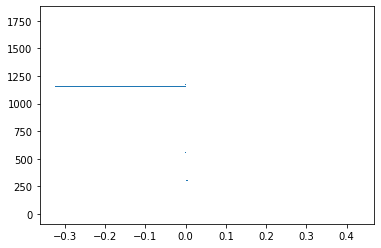

In [94]:
plt.barh(np.arange(len(gas.net_rates_of_progress)),gas.net_rates_of_progress)

In [95]:
gas.T

2514.3027839901165

In [96]:
data = pd.read_csv(output_filename)
data

,Distance (mm),T (C),P (atm),Ne,NH3(2),NH2OH(3),HNO3(4),CH3OH(5),H2O(6),N2(7),...,SX(4937),SX(5513),SX(5810),SX(5814),SX(6977),SX(7604),SX(9643),gas_heat,surface_heat,alpha
0,0.000000,259.632724,1.004706,0.000000e+00,0.033695,3.071460e-01,3.376088e-01,2.167726e-01,0.104778,2.037751e-46,...,5.572984e-24,1.879934e-24,4.055267e-14,3.706422e-25,3.635759e-17,3.028288e-39,3.409764e-54,1.112559e+02,-3.542859e+12,1.000000
1,0.003874,652.810000,1.000080,0.000000e+00,0.055801,2.306563e-01,3.272086e-01,1.482261e-01,0.187626,4.190155e-15,...,2.028466e-12,2.791026e-15,1.358298e-14,2.366872e-17,7.602520e-07,1.295684e-23,5.942924e-32,1.450435e+09,-1.178060e+12,1.001233
2,0.007748,652.810000,1.000080,0.000000e+00,0.055801,2.306563e-01,3.272086e-01,1.482261e-01,0.187626,4.190155e-15,...,2.028466e-12,2.791026e-15,1.358298e-14,2.366872e-17,7.602520e-07,1.295684e-23,5.942924e-32,1.450435e+09,-1.178060e+12,1.001233
3,0.011622,652.810000,1.000080,0.000000e+00,0.055801,2.306563e-01,3.272086e-01,1.482261e-01,0.187626,4.190155e-15,...,2.028466e-12,2.791026e-15,1.358298e-14,2.366872e-17,7.602520e-07,1.295684e-23,5.942924e-32,1.450435e+09,-1.178060e+12,1.001233
4,0.015496,652.810000,1.000080,0.000000e+00,0.055801,2.306563e-01,3.272086e-01,1.482261e-01,0.187626,4.190155e-15,...,2.028466e-12,2.791026e-15,1.358298e-14,2.366872e-17,7.602520e-07,1.295684e-23,5.942924e-32,1.450435e+09,-1.178060e+12,1.001233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,7.732572,2240.764381,1.000000,4.763656e-27,0.000002,3.004829e-10,6.141673e-11,4.634224e-13,0.618718,7.867095e-02,...,2.985707e-18,1.998613e-14,3.988748e-15,3.614327e-19,2.639493e-05,4.195366e-18,8.714720e-22,-1.151980e+08,-5.437569e+06,0.045074
1997,7.736446,2240.861523,1.000000,4.763670e-27,0.000002,3.001675e-10,6.145440e-11,4.627006e-13,0.618730,7.868948e-02,...,2.972964e-18,1.999593e-14,3.988449e-15,3.614910e-19,2.640171e-05,4.197959e-18,8.721218e-22,-1.152205e+08,-5.381914e+06,0.044625
1998,7.740320,2240.958637,1.000000,4.763683e-27,0.000002,2.998527e-10,6.149208e-11,4.619809e-13,0.618742,7.870801e-02,...,2.960265e-18,2.000573e-14,3.988149e-15,3.615492e-19,2.640850e-05,4.200552e-18,8.727713e-22,-1.152430e+08,-5.326252e+06,0.044176
1999,7.744194,2241.055724,1.000000,4.763697e-27,0.000002,2.995384e-10,6.152976e-11,4.612633e-13,0.618754,7.872654e-02,...,2.947611e-18,2.001552e-14,3.987848e-15,3.616072e-19,2.641528e-05,4.203143e-18,8.734205e-22,-1.152654e+08,-5.270579e+06,0.043726


In [97]:
last_row = np.array(data.tail(1))
np.shape(last_row)

(1, 272)

In [98]:
def xlabels():
    plt.xticks([0,NReactors/4,NReactors/2,3*NReactors/4, NReactors],['0','','','',f'{length*1000:.0f} mm'])
    plt.xlabel("Distance down reactor")

In [99]:
def title():
    plt.title('T: {:}C, L/D: {:.2f}, FR: {:.2f}g/s'.format(temperature_c, L_D, injection_speed))

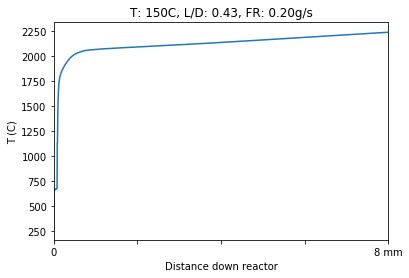

In [100]:
data['T (C)'].plot()
plt.ylabel('T (C)')
xlabels()
title()

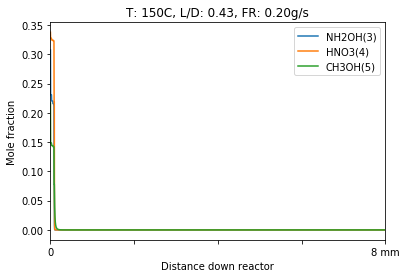

In [101]:
data[['NH2OH(3)', 'HNO3(4)', 'CH3OH(5)']].plot()
plt.ylabel('Mole fraction')
xlabels()
title()

In [102]:
list(data.columns)[:4]

['Distance (mm)', 'T (C)', 'P (atm)', 'Ne']

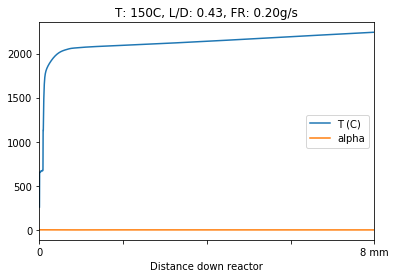

In [103]:
data[['T (C)', 'alpha']].plot()
xlabels()
title()

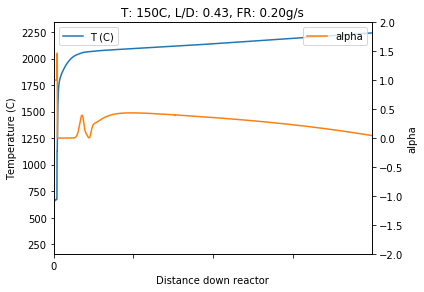

In [104]:
ax1 = data['T (C)'].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.legend()
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, color='tab:orange')
ax2.set_ylim(-2, 2)
plt.legend()
plt.ylabel('alpha')
plt.tight_layout()
title()
plt.savefig('temperature-and-alpha.pdf')
plt.show()

In [105]:
data.columns

Index(['Distance (mm)', 'T (C)', 'P (atm)', 'Ne', 'NH3(2)', 'NH2OH(3)',
       'HNO3(4)', 'CH3OH(5)', 'H2O(6)', 'N2(7)',
       ...
       'SX(4937)', 'SX(5513)', 'SX(5810)', 'SX(5814)', 'SX(6977)', 'SX(7604)',
       'SX(9643)', 'gas_heat', 'surface_heat', 'alpha'],
      dtype='object', length=272)

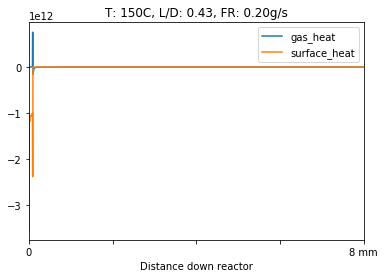

In [106]:
data[['gas_heat','surface_heat']].plot()
#plt.ylim(-1e7, 1e7)
xlabels()
title()
plt.savefig('gas_and_surface_heat.pdf')
plt.show()


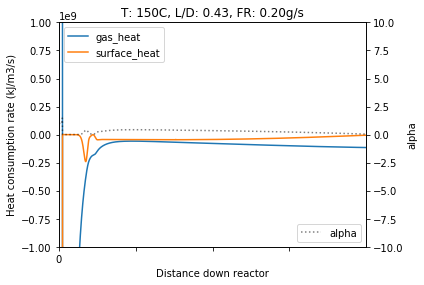

In [107]:
ax1 = data[['gas_heat','surface_heat']].plot()
plt.ylim(-1e9, 1e9)
xlabels()
plt.ylabel('Heat consumption rate (kJ/m3/s)')
plt.legend(loc='upper left')
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, style='k:', alpha=0.5)
ax2.set_ylim(-10, 10)
plt.legend(loc='lower right')
plt.ylabel('alpha')
plt.tight_layout()
title()
plt.savefig('heats-and-alpha.pdf')
plt.show()

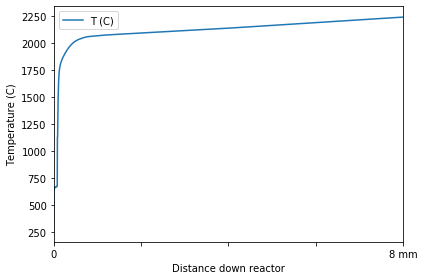

In [108]:
data[['T (C)']].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.tight_layout()
plt.savefig('temperature.pdf')
plt.show()

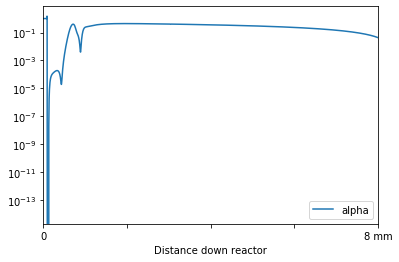

In [109]:
data[['alpha']].plot(logy=True)
xlabels()

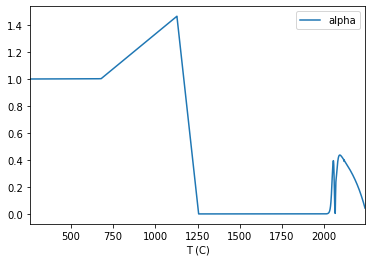

In [110]:
data.plot(x='T (C)',y='alpha')


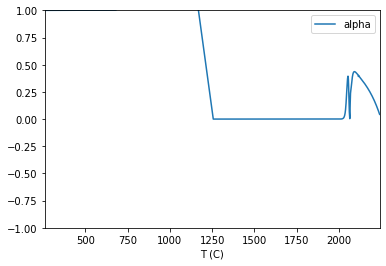

In [111]:
data.plot(x='T (C)',y='alpha', ylim=(-1,1))

In [112]:
specs = list(data.columns)
specs = specs[4:-1]

gas_species = [s for s in specs if 'X' not in s]
adsorbates = [s for s in specs if 'X' in s]

gas_species, adsorbates

(['NH3(2)',
  'NH2OH(3)',
  'HNO3(4)',
  'CH3OH(5)',
  'H2O(6)',
  'N2(7)',
  'O2(8)',
  'NO2(9)',
  'NO(10)',
  'N2O(11)',
  'CO2(12)',
  'H2(13)',
  'CO(14)',
  'CH4(15)',
  'C2H6(16)',
  'CH2O(17)',
  'CH3(18)',
  'C3H8(19)',
  'H(20)',
  'C2H5(21)',
  'HCO(22)',
  'CH3CHO(23)',
  'OH(24)',
  'C2H4(25)',
  'O(36)',
  'Ar(37)',
  'HO2(39)',
  'H2O2(40)',
  'HOCO(41)',
  'CH2(42)',
  'CH2(S)(43)',
  'CH(44)',
  'CH2OH(45)',
  'CH3O(46)',
  'HCOH(47)',
  'CH3OO(48)',
  'CH2CO(49)',
  'C2H3(50)',
  'C(51)',
  'C2H2(52)',
  'C2H(53)',
  'CH3OOH(54)',
  'CH2OOH(55)',
  'HOCH2O(56)',
  'HOCHO(57)',
  'C2H5O(58)',
  'C2H5O2(59)',
  'C2H5O2(60)',
  'cC2H4O(61)',
  'CH2CHO(62)',
  'H2CC(63)',
  'CH3CO(64)',
  'C2H4O(65)',
  'C2H5O(66)',
  'C2H3O2(67)',
  'CHCHO(68)',
  'OCHCHO(69)',
  'HCCO(70)',
  'HCCOH(71)',
  'CHCHOH(72)',
  'C2(73)',
  'C2O(74)',
  'C2H6O(75)',
  'C2H5O(76)',
  'C2H5O3(77)',
  'cC2H3O(78)',
  'C2H3O3(79)',
  'OCHCO(80)',
  'C2H6O2(81)',
  'C2H5O2(82)',
  'C2H4O2(83)',
  

/home/nadeau.ma/.conda/envs/rmg_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


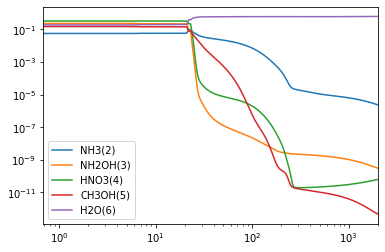

In [113]:
data[gas_species[0:5]].plot(logy=True, logx=True)

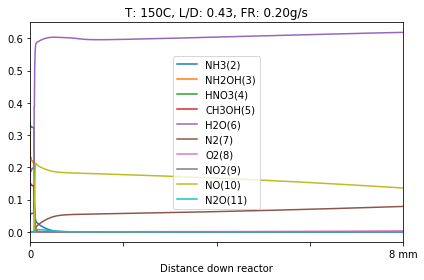

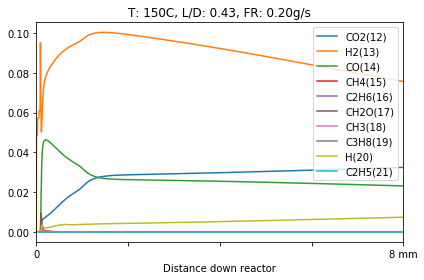

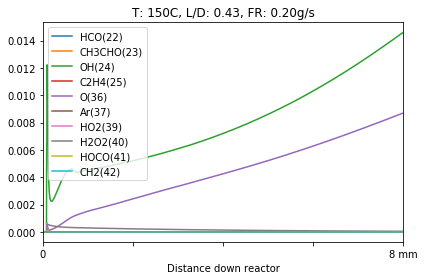

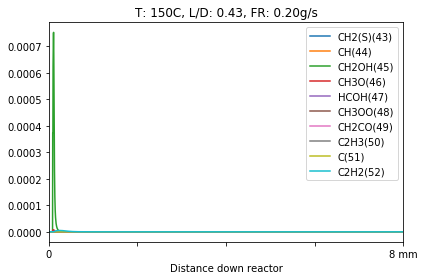

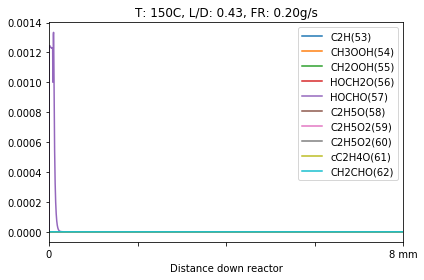

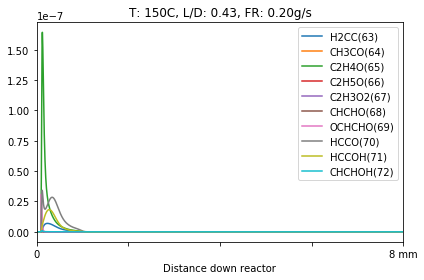

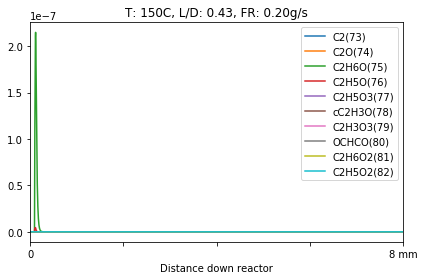

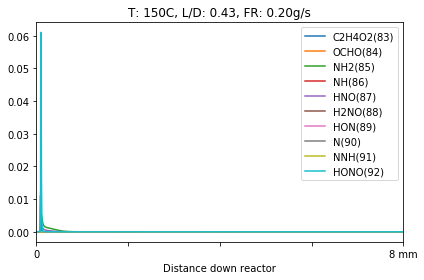

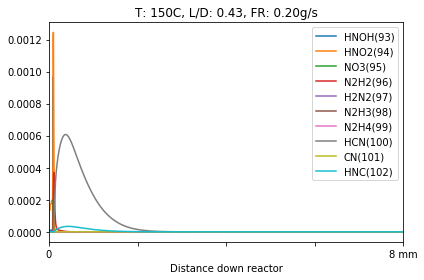

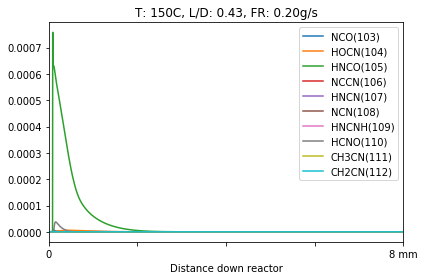

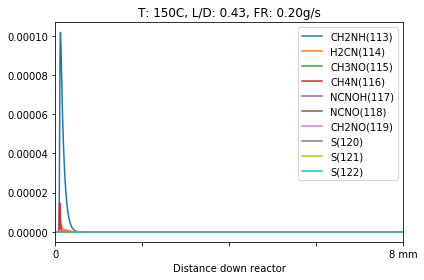

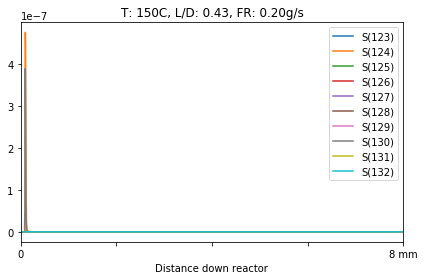

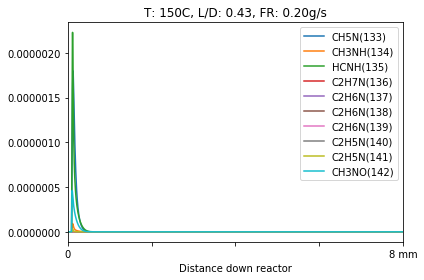

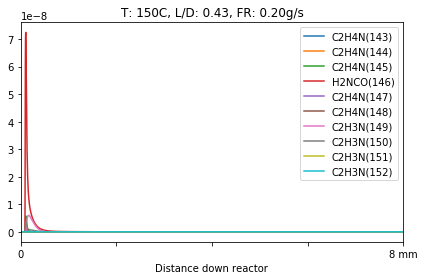

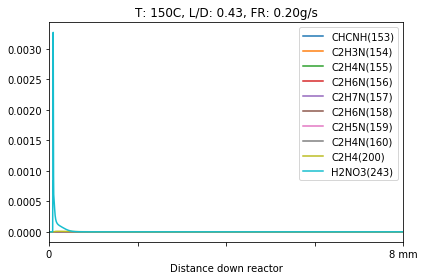

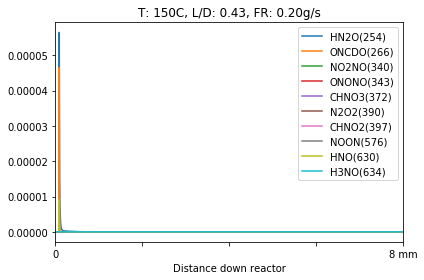

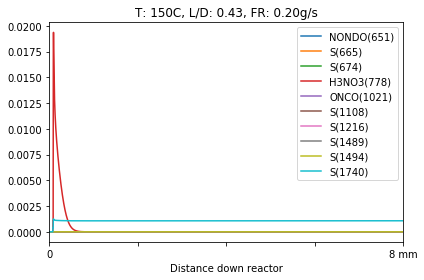

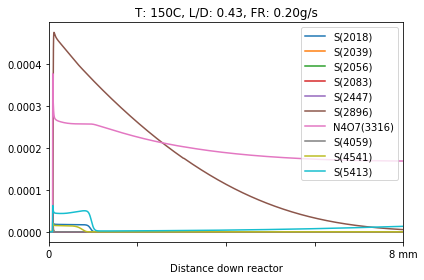

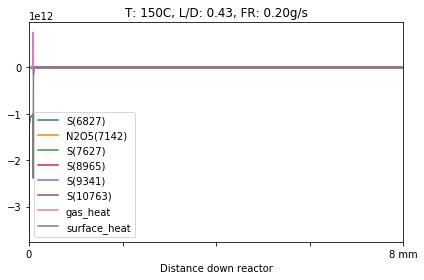

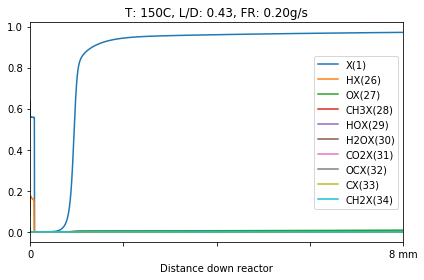

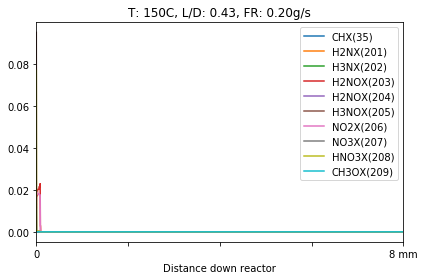

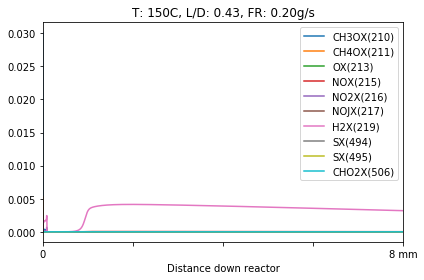

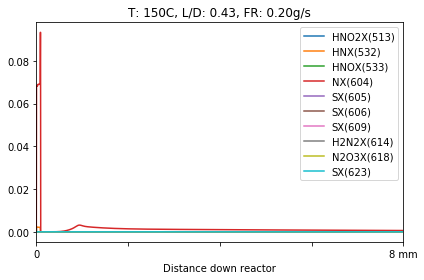

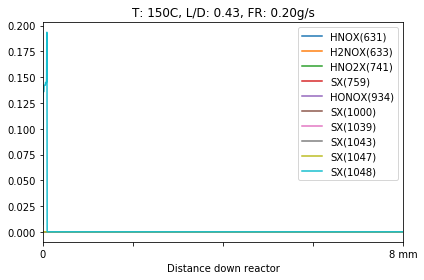

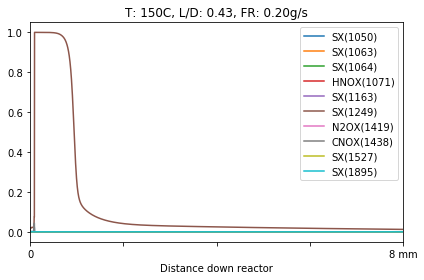

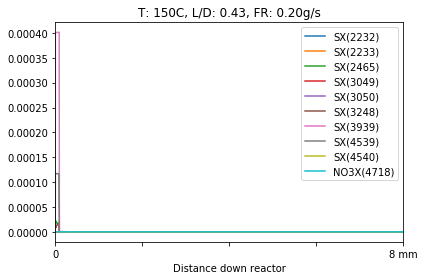

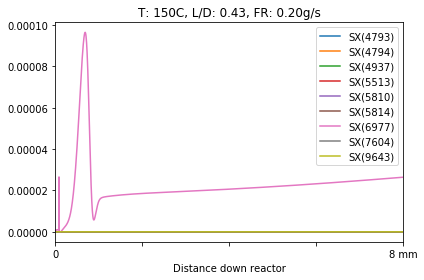

In [114]:
for i in range(0,len(gas_species),10):
    data[gas_species[i:i+10]].plot(title='gas mole fraction', logy=False)
    xlabels()
    plt.tight_layout()
    title()
    plt.savefig(f'gas_mole_fractions_{i}.pdf')
    plt.show()
    
for i in range(0,len(adsorbates),10):
    data[adsorbates[i:i+10]].plot(title='surface coverages', logy=False)
    xlabels()
    plt.tight_layout()
    title()
    plt.savefig(f'surface_coverages_{i}.pdf')
    plt.show()

In [115]:
gas.species('NO2(9)').composition

{'N': 1.0, 'O': 2.0}

In [116]:
gas.partial_molar_volumes
# gas.species('CH3OH(5)').D
gas().D


  gas:

       temperature          2514.3  K
          pressure          101325  Pa
           density       0.0982759  kg/m^3
  mean mol. weight          20.276  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      -2.855e+06       -5.789e+07     J
   internal energy      -3.886e+06       -7.879e+07     J
           entropy           13786        2.795e+05     J/K
    Gibbs function     -3.7518e+07       -7.607e+08     J
 heat capacity c_p          2325.5        4.715e+04     J/K
 heat capacity c_v          1915.4        3.884e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
            NH3(2)    2.31648e-06       1.9457e-06         -45.4909
          NH2OH(3)    2.99225e-10      4.87442e-10         -62.2589
           HNO3(4)    6.15674e-11      1.91337e-10         -73.7454
          CH3OH(5)    4.6054

AttributeError: 'NoneType' object has no attribute 'D'

In [ ]:
gas.T #K
gas.P #Pa

In [ ]:
last_value = len(data['NO2(9)'])-1
no2 = data.at[last_value,'NO2(9)']
no = data.at[last_value,'NO(10)']
no2_no = no2 + no
h2 = data.at[last_value,'H2(13)']
o2 = data.at[last_value,'O2(8)']
n2 = data.at[last_value,'N2(7)']
ch4 = data.at[last_value,'CH4(15)']
co = data.at[last_value,'CO(14)']
co2 = data.at[last_value,'CO2(12)']
n2o = data.at[last_value,'N2O(11)']

product_gases = np.array([no2_no,h2,o2,n2,ch4,co,co2,n2o])*100
product_gases

# plt.plot(np.ones_like(product_gases)*.611,product_gases,'*')
# plt.yscale('log')
# ld = .611
# ax1 = data.plot(kind='scatter', x=ld, y='NO2(9)',color = 'r')

In [ ]:
def xlabels_ld():
    plt.xticks([0,NReactors/4,NReactors/2,3*NReactors/4, NReactors],['0','','','',f'{length*1000:.0f} mm'])
    plt.xlabel("Distance down reactor")
    D = 1.8*cm 
    LD = length/D

In [ ]:
D = 1.8*cm
length/D
gas_species

In [ ]:
data['N2(7)']

In [ ]:
violators = []
for j in range(len(surf.reactions())):

    for key in surf.reactions()[j].reactants:
        if key in gas.species_names:
            k = gas.species_names.index(key)
            print(surf.reaction(j))
            print('species index:',k,'\nchemkin rxn num:',j+1)
            T = surf.T
            R = ct.gas_constant #J/kmol-K   
            # surf.reactant_stoich_coeffs() array of stoich coefficients. [k,i] is elements k in rxn i
            # surf.reactant_stoich_coeff(k,j) #stoich coeff of reactant k in rxn j
            #m is the sum of the species on the surface's stoichiometric coefficients
            m = sum(surf.reactant_stoich_coeffs()[:,j])-surf.reactant_stoich_coeff(k,j)
            gamma = surf.site_density #kmol/m^2
            W = gas.molecular_weights[k] #MW of gas kg/kmol
            print('m = {0}, MW = {1} #kg/kmol, species {2}'.format(m,W,gas.species_names[k]))
            stick = surf.forward_rate_constants[j]*gamma**m/(np.sqrt(R*T/(2*np.pi*gas.molecular_weights[k])))
            violation = stick > 1
            print('Violator?',violation,'. Stick:{:.2}'.format(stick), '\n')
            if violation:
#                 print(surf.reaction(j))
#                 print(k)
#                 print('m = {0}, MW = {1} #kg/kmol, species {2}'.format(m,W,gas.species_names[k]))
#                 print('cantera kf is {:.1e}'.format(surf.forward_rate_constants[j]))
#         #     print("Calculated kf = cantera's kf?", test == surf.forward_rate_constants[j])
#                 print(violation, stick)
#                 print('\n')
                violators.append(surf.reaction(j))

In [ ]:
(data[specs].max()>0.01)

In [ ]:
violators

In [ ]:
data.loc[0]

In [ ]:
def stick_greater_than_1(T):
    '''
    For a given T  in Kelvin, returns a list of rxns for which Cantera 
    calculated the forward rate constant based on a sticking coefficient
    greater than 1
    '''
    violators = []
    sticks = []
    violator_rxn_indeces = []
    for j in range(len(surf.reactions())):

        # surf.reactant_stoich_coeffs() array of stoich coefficients. [k,i] is elements k in rxn i
        # surf.reactant_stoich_coeff(k,j) #stoich coeff of reactant k in rxn j
        for key in surf.reactions()[j].reactants:
            if key in gas.species_names:
                k = gas.species_names.index(key)
#                 print(surf.reaction(j))
#                 print(k)
                R = ct.gas_constant #J/kmol-K        
                m = sum(surf.reactant_stoich_coeffs()[:,j])-surf.reactant_stoich_coeff(k,j)
                gamma = surf.site_density #kmol/m^2
                W = gas.molecular_weights[k] #MW of gas kg/kmol
            #     print('m = {0}, MW = {1} #kg/kmol, species {2}'.format(m,W,gas.species_names[k]))
                stick = surf.forward_rate_constants[j]*gamma**m/(np.sqrt(R*T/(2*np.pi*gas.molecular_weights[k])))
                violation = stick > 1
            #     print(violation, stick)
#                 print(stick,'\n')
                if violation:
                    violators.append(surf.reaction(j))
                    sticks.append(stick)
                    violator_rxn_indeces.append(j)

    #     print('kf is {:.1e}'.format(test))

    return violators,sticks,violator_rxn_indeces

print("Reactions with sticking coeff > 1 :")
print("(Note: reported kf is at the temperature determined by the reactor network)\n")
Temps = np.linspace(20+273.15,1000+273.15,num=5)
for t in range(len(Temps)):
    Temp = Temps[t]
    rxns, values, indeces = stick_greater_than_1(Temp)
    print(f"{'Temp(C)'}      {'Rxns':44s}  {'i_Rxn':}   {'Stick(T)':}  {'kf at surf.T':}")
    for i in range(len(indeces)):
        print(f"{Temp-273.15:4.4}      {str(rxns[i]):48s}  {np.array(indeces[i])+1:3d}    {values[i]:5.2f}     {surf.forward_rate_constants[indeces[i]]:.2e}")
    print('\n')
# Temp = 20+273.15
# rxns, values, indeces = stick_greater_than_1(Temp)
# print("Reactions with sticking coeff > 1 :\n")
# print('Temp (C)             Rxns                 i_Rxn      Stick')
# for i in range(len(indeces)):
#     print('',Temp-273.15, '    ' ,rxns[i], '     ', np.array(indeces[i])+1, '     ','{:.3}'.format(values[i]))